<a href="https://colab.research.google.com/github/Ssurf777/VAE_sample/blob/main/AE_%3EVAE_MNIST_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# memo
# 高解像度のVAE Vector Quantised VAE
# 再構成誤差＋正則化項が重要
# テクニック μ logσ2

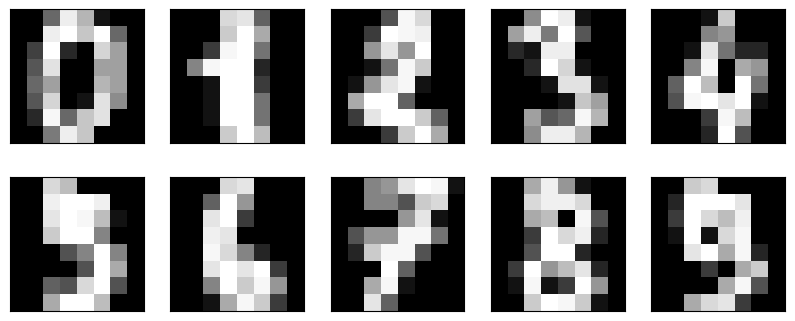

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [2]:
# data import
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10  # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
    # 入力画像
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)  # 軸を非表示に
    ax.get_yaxis().set_visible(False)
plt.show()

print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
from torch.utils.data import DataLoader

# -- 各設定値 --
img_size = 8  # 画像の高さと幅
n_in_out = img_size * img_size  # 入出力層のニューロン数
n_mid = 16  # 中間層のニューロン数

eta = 0.01  # 学習係数
epochs = 100
batch_size = 16
interval = 10  # 経過の表示間隔

# -- 訓練データ --
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 16  # 0-1の範囲に

x_train = torch.tensor(x_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(x_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model 構築

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(n_in_out, n_mid)  # Encoder
        self.decoder = nn.Linear(n_mid, n_in_out)  # Decoder

    def forward(self, x):
        x = x.view(-1, n_in_out)  # バッチサイズ×入力の数
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x

    def encode(self, x):
        x = x.view(-1, n_in_out)  # バッチサイズ×入力の数
        x = F.relu(self.encoder(x))
        return x

autoencoder = Autoencoder()
autoencoder.cuda()  # GPU対応
print(autoencoder)

Autoencoder(
  (encoder): Linear(in_features=64, out_features=16, bias=True)
  (decoder): Linear(in_features=16, out_features=64, bias=True)
)


Training

In [5]:
from torch import optim

# 二乗和誤差
loss_fnc = nn.MSELoss()

# Adam
optimizer = optim.Adam(autoencoder.parameters())

# 損失のログ
record_loss_train = []

# 学習
for i in range(epochs):
    autoencoder.train()  # 訓練モード
    loss_train = 0
    for j, (x,) in enumerate(train_loader):  # ミニバッチ（x,）を取り出す
        x = x.cuda()  # GPU対応
        y = autoencoder(x)
        loss = loss_fnc(y, x)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%interval == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)

Epoch: 0 Loss_Train: 0.1328039425796112
Epoch: 10 Loss_Train: 0.02386824155341735
Epoch: 20 Loss_Train: 0.015975199895292783
Epoch: 30 Loss_Train: 0.012522135861217976
Epoch: 40 Loss_Train: 0.011296957929049972
Epoch: 50 Loss_Train: 0.01076282875661829
Epoch: 60 Loss_Train: 0.01046622175294741
Epoch: 70 Loss_Train: 0.010238452822761198
Epoch: 80 Loss_Train: 0.01005606079655411
Epoch: 90 Loss_Train: 0.009919421982217944


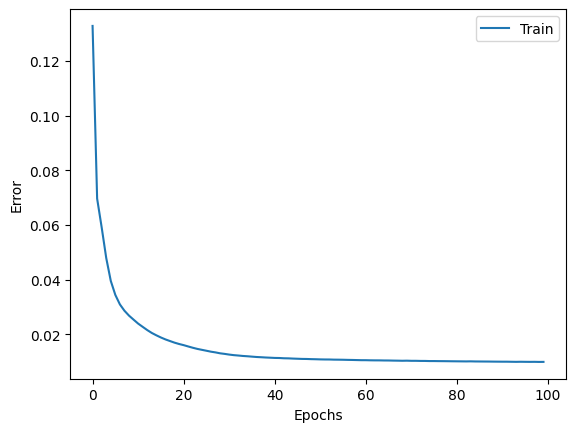

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

生成された画像の表示

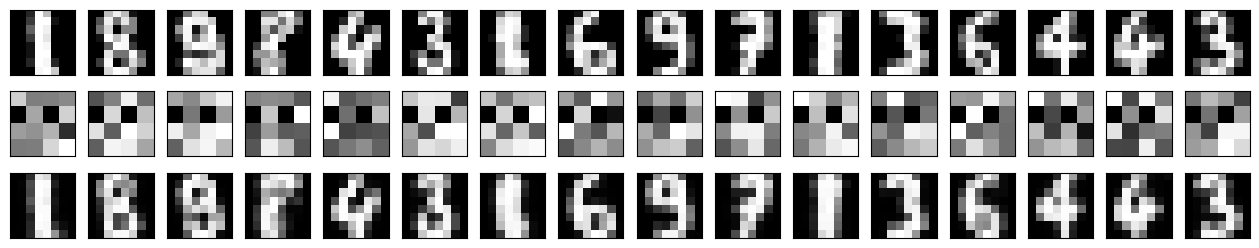

In [7]:
n_img = batch_size  # 表示する画像の数
x = next(iter(train_loader))[0]
x = x.cuda()

autoencoder.eval()  # 評価モード
m = autoencoder.encode(x)  # 中間層の状態
y = autoencoder(x)

# NumPyの配列に変換
x_sample = x.cpu().detach().numpy()
m_sample = m.cpu().detach().numpy()
y_sample = y.cpu().detach().numpy()

plt.figure(figsize=(n_img, 3))
for i in range(n_img):
    # 入力画像
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_sample[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 中間層の出力
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(m_sample[i].reshape(4, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 出力画像
    ax = plt.subplot(3, n_img, i+1+2*n_img)
    plt.imshow(y_sample[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


中間層のニューロンが少ないとどうなるか？

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
from torch.utils.data import DataLoader

# -- 各設定値 --
img_size = 8  # 画像の高さと幅
n_in_out = img_size * img_size  # 入出力層のニューロン数
n_mid = 4  # 中間層のニューロン数

eta = 0.01  # 学習係数
epochs = 100
batch_size = 16
interval = 10  # 経過の表示間隔

# -- 訓練データ --
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 16  # 0-1の範囲に

x_train = torch.tensor(x_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(x_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(n_in_out, n_mid)  # Encoder
        self.decoder = nn.Linear(n_mid, n_in_out)  # Decoder

    def forward(self, x):
        x = x.view(-1, n_in_out)  # バッチサイズ×入力の数
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x

    def encode(self, x):
        x = x.view(-1, n_in_out)  # バッチサイズ×入力の数
        x = F.relu(self.encoder(x))
        return x

autoencoder = Autoencoder()
autoencoder.cuda()  # GPU対応
print(autoencoder)

Autoencoder(
  (encoder): Linear(in_features=64, out_features=4, bias=True)
  (decoder): Linear(in_features=4, out_features=64, bias=True)
)


In [14]:
from torch import optim

# 二乗和誤差
loss_fnc = nn.MSELoss()

# Adam
optimizer = optim.Adam(autoencoder.parameters())

# 損失のログ
record_loss_train = []

# 学習
for i in range(epochs):
    autoencoder.train()  # 訓練モード
    loss_train = 0
    for j, (x,) in enumerate(train_loader):  # ミニバッチ（x,）を取り出す
        x = x.cuda()  # GPU対応
        y = autoencoder(x)
        loss = loss_fnc(y, x)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%interval == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)

Epoch: 0 Loss_Train: 0.16042309181880107
Epoch: 10 Loss_Train: 0.05985481259042183
Epoch: 20 Loss_Train: 0.054838872424005404
Epoch: 30 Loss_Train: 0.05044560282763127
Epoch: 40 Loss_Train: 0.048865966465884605
Epoch: 50 Loss_Train: 0.047740763762092166
Epoch: 60 Loss_Train: 0.04695069809666777
Epoch: 70 Loss_Train: 0.0461843773986386
Epoch: 80 Loss_Train: 0.04565419081961159
Epoch: 90 Loss_Train: 0.04500878579189292


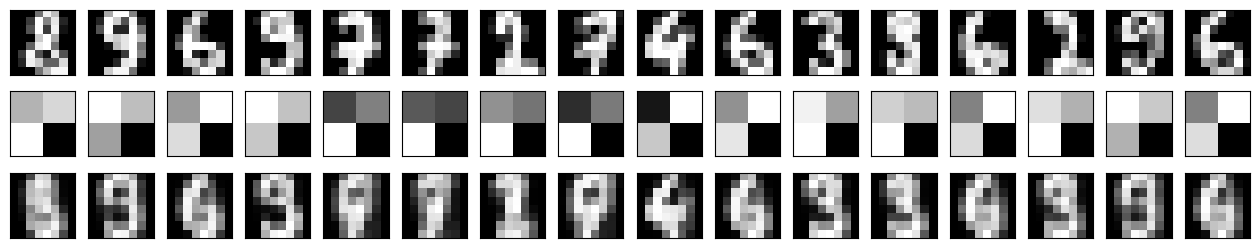

In [16]:
n_img = batch_size  # 表示する画像の数
x = next(iter(train_loader))[0]
x = x.cuda()

autoencoder.eval()  # 評価モード
m = autoencoder.encode(x)  # 中間層の状態
y = autoencoder(x)

# NumPyの配列に変換
x_sample = x.cpu().detach().numpy()
m_sample = m.cpu().detach().numpy()
y_sample = y.cpu().detach().numpy()

plt.figure(figsize=(n_img, 3))
for i in range(n_img):
    # 入力画像
    ax = plt.subplot(3, n_img, i+1)
    plt.imshow(x_sample[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 中間層の出力
    ax = plt.subplot(3, n_img, i+1+n_img)
    plt.imshow(m_sample[i].reshape(2, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 出力画像
    ax = plt.subplot(3, n_img, i+1+2*n_img)
    plt.imshow(y_sample[i].reshape(img_size, -1).tolist(), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# VAEの実装
VAEを実装します。  
Encoderで手書き数字画像を潜在変数に圧縮した後、Decoderで元の画像を再構築します。  
さらに、潜在変数が分布する潜在空間を可視化した上で、潜在変数を調整し生成画像の変化を確かめます。    

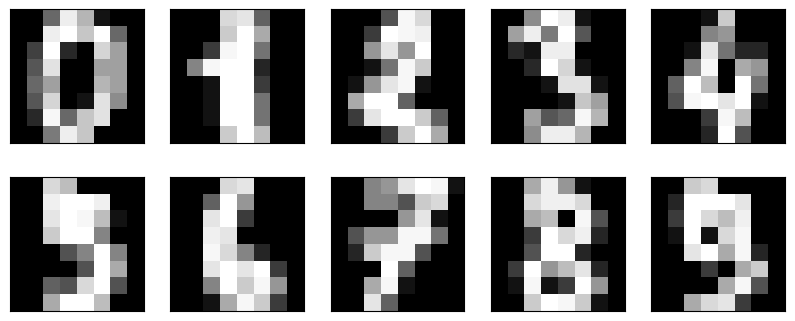

データの形状: (1797, 64)
ラベル: [0 1 2 3 4 5 6 7 8 9]


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()

n_img = 10  # 表示する画像の数
plt.figure(figsize=(10, 4))
for i in range(n_img):
    # 入力画像
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)  # 軸を非表示に
    ax.get_yaxis().set_visible(False)
plt.show()

print("データの形状:", digits_data.data.shape)
print("ラベル:", digits_data.target[:n_img])

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
from torch.utils.data import DataLoader

# -- 各設定値 --
img_size = 8  # 画像の高さと幅
n_in_out = img_size * img_size  # 入出力層のニューロン数
n_mid = 16  # 中間層のニューロン数
n_z = 2  # 潜在変数の数　ここがAutoEncoderとの違い

eta = 0.01  # 学習係数
epochs = 100
batch_size = 16
interval = 10  # 経過の表示間隔

# -- 訓練データ --
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train /= 16  # 0-1の範囲に

x_train = torch.tensor(x_train, dtype=torch.float)
train_dataset = torch.utils.data.TensorDataset(x_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## モデルの構築
PyTorchよりVAEのモデルを構築します。  
Encoderの出力は、潜在変数の平均値$\mu$および、標準偏差$\sigma$の2乗（=分散）の対数とします。  
   
VAEのコードでは、バックプロパゲーションによる学習のためにReparametrization Trickが使われます。    
平均値0標準偏差1のノイズεを発生させて、標準偏差$\sigma$とかけて平均値$\mu$に加えることで、潜在変数$z$とします。  
$$\epsilon \sim N(0,\, I)$$
$$z=\mu + \epsilon\odot\sigma$$
  
損失関数は、以下で表されます。  

$$E=E_{rec} + E_{reg}$$

ここで、右辺第一項の再構成誤差$E_{rec}$は、出力と入力のずれを表します。  
$$E_{rec} = \frac{1}{h}\sum_{i=1}^{h}\sum_{j=1}^{m}\left(-x_{ij}\log y_{ij}-(1-x_{ij})log(1-y_{ij})\right)$$
$h$:バッチサイズ、￼$m$:入出力層のニューロン数、￼$x_{ij}$: VAEの入力、$y_{ij}$: VAEの出力   
また、右辺第二項の正則化項$E_{reg}$は、平均値が0に、標準偏差が1に近づくように機能します。  
$$E_{reg}=\frac{1}{h}\sum_{i=1}^{h}\sum_{k=1}^{n}-\frac{1}{2}(1+\phi_{ik} - \mu_{ik}^2 - exp(\phi_{ik}))$$
$h$:バッチサイズ、￼$n$:潜在変数の数、￼$\mu_{ik}$: 平均値、$\phi_{ik}$: 分散の対数   

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_mid = nn.Linear(n_in_out, n_mid)  # Encoderの中間層
        self.enc_mu = nn.Linear(n_mid, n_z)  # 平均値を求める層
        self.enc_logvar = nn.Linear(n_mid, n_z)  # 分散のlogを求める層

        self.dec_mid = nn.Linear(n_z, n_mid)  # Decoderの中間層
        self.dec_out = nn.Linear(n_mid, n_in_out)  # Decoderの出力層

    def forward(self, x):
        z = self.encode(x)
        y = self.decode(z)
        return y

    def encode(self, x):
        x = x.view(-1, n_in_out)  # バッチサイズ×入力の数

        x = F.relu(self.enc_mid(x))
        self.mu = self.enc_mu(x)
        self.logvar = self.enc_logvar(x)

        std = torch.exp(0.5*self.logvar)  # 標準偏差
        eps = torch.randn_like(std)  # 正規分布に従う乱数
        return self.mu + std*eps  # 潜在変数（reparametrization trick）

    def decode(self, z):
        x = F.relu(self.dec_mid(z))
        x = F.sigmoid(self.dec_out(x))
        return x

    def loss(self, y, x):
        x = x.view(-1, n_in_out)  # バッチサイズ×入力の数

        rec_loss = F.binary_cross_entropy(y, x, reduction="sum")  # 再構成誤差
        reg_loss = 0.5 * torch.sum(self.mu**2 + torch.exp(self.logvar)- self.logvar - 1)  # 正則化項
        return (rec_loss, reg_loss)

vae = VAE()
vae.cuda()  # GPU対応
print(vae)

VAE(
  (enc_mid): Linear(in_features=64, out_features=16, bias=True)
  (enc_mu): Linear(in_features=16, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=16, out_features=2, bias=True)
  (dec_mid): Linear(in_features=2, out_features=16, bias=True)
  (dec_out): Linear(in_features=16, out_features=64, bias=True)
)


## 学習
構築したVAEのモデルを使って、学習を行います。  
入力を再現するように学習するので、正解は必要ありません。

In [22]:
from torch import optim

# Adam
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

# 学習
for i in range(epochs):
    vae.train()  # 訓練モード
    loss_rec = 0
    loss_reg = 0
    loss_total = 0

    for j, (x,) in enumerate(train_loader):  # ミニバッチ（x,）を取り出す
        x = x.cuda()  # GPU対応
        y = vae(x)
        lrec, lreg = vae.loss(y, x)
        loss = lrec + lreg
        loss_rec += lrec.item()
        loss_reg += lreg.item()
        loss_total += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_rec /= j+1
    loss_reg /= j+1
    loss_total /= j+1
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    if i%interval == 0:
        print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 633.874218020819 Loss_Reg: 2.712330428899917 Loss_Total: 636.5865478515625
Epoch: 10 Loss_Rec: 394.08875727020535 Loss_Reg: 19.531628604483814 Loss_Total: 413.6203860392613
Epoch: 20 Loss_Rec: 387.8158698968128 Loss_Reg: 22.538956785624006 Loss_Total: 410.354826260457
Epoch: 30 Loss_Rec: 381.3200150886468 Loss_Reg: 24.539858269480476 Loss_Total: 405.85987273359723
Epoch: 40 Loss_Rec: 374.81548680668385 Loss_Reg: 27.858026015020048 Loss_Total: 402.67351282170387
Epoch: 50 Loss_Rec: 371.21519389194725 Loss_Reg: 30.129949248997512 Loss_Total: 401.3451417230927
Epoch: 60 Loss_Rec: 368.6119321975033 Loss_Reg: 31.335240001172092 Loss_Total: 399.9471721817962
Epoch: 70 Loss_Rec: 367.42167434017216 Loss_Reg: 31.19887294600495 Loss_Total: 398.62054699923084
Epoch: 80 Loss_Rec: 365.9952234588893 Loss_Reg: 31.9483674142213 Loss_Total: 397.94359136260715
Epoch: 90 Loss_Rec: 365.5613569411556 Loss_Reg: 32.91985734585112 Loss_Total: 398.4812144051611


## 誤差の推移
記録された誤差の、推移を確認します。

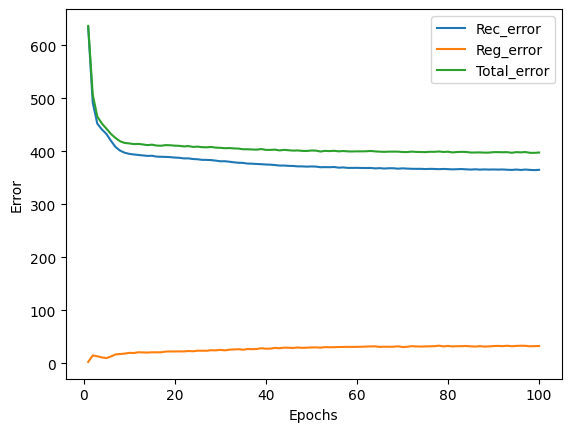

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

再構成誤差（Rec_error）と正則化項（Reg_error）が均衡し、全体の誤差（Total_error）が動かなくなることが確認できます。  
潜在変数は範囲を広げることで入出力を一致させようとするのですが、これを正則化項が抑制していることになります。

## 潜在空間の可視化
2つの潜在変数を平面にプロットし、潜在空間を可視化します。  
入力画像はそれが何の数であるかを示すラベルとペアになっているので、このラベルを文字として潜在空間にプロットします。  

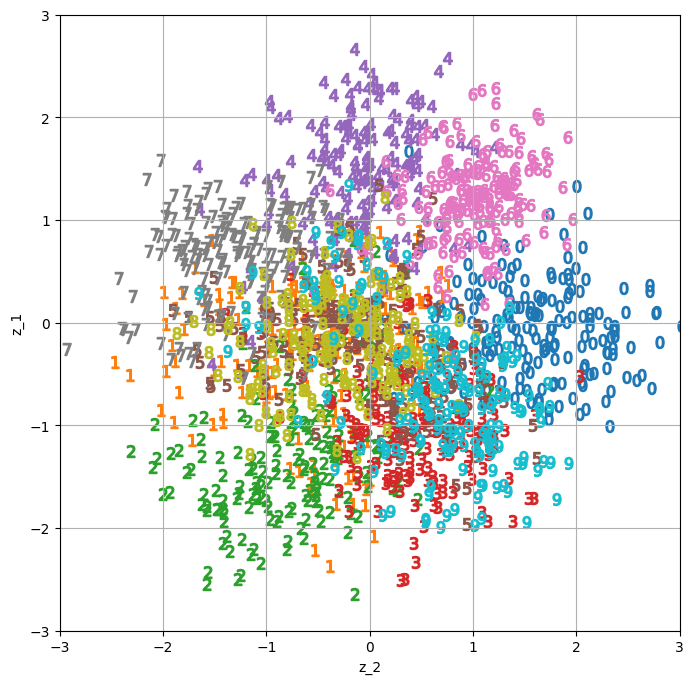

In [25]:
# 潜在変数を計算
vae.eval()  # 評価モード
x = x_train.cuda()
z = vae.encode(x)  # 潜在変数
z = z.cpu().detach().numpy()

t = np.asarray(digits_data.target)  # ラベル

# 潜在変数を平面にプロット
plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z[t==i]
    z_1 = zt[:, 0]  # y軸
    z_2 = zt[:, 1]  # x軸
    marker = "$"+str(i)+"$"  # 数値をマーカーに
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid()
plt.show()

各ラベルごとに、異なる潜在空間の領域が占められていることが確認できます。  
このように、VAEは入力を潜在空間に割り当てるように学習します。  


### 画像の生成
潜在変数を連続的に変化させて、生成される画像がどのように変化するのかを確かめます。  
訓練済みVAEのDecoderを使って、画像を16×16枚生成します。

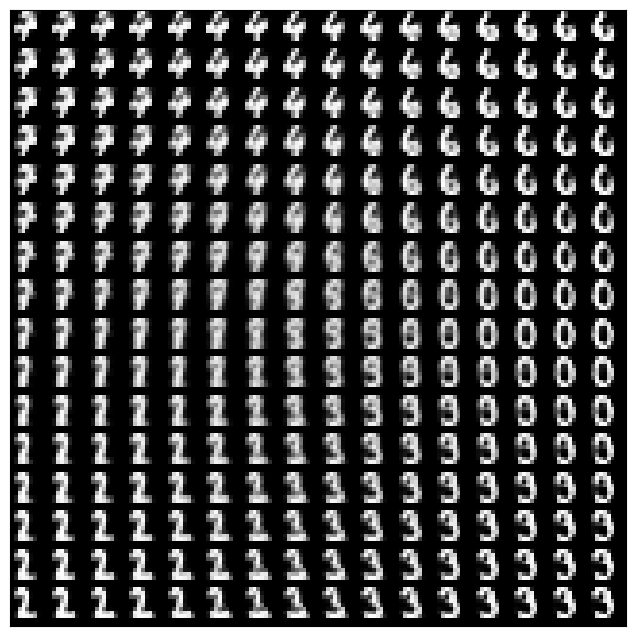

In [26]:
# 画像の設定
n_img = 16  # 画像を16x16並べる
img_size_spaced = img_size + 2
matrix_image = np.zeros((img_size_spaced*n_img, img_size_spaced*n_img))  # 全体の画像

# 潜在変数
z_1 = np.linspace(3, -3, n_img)  # 行
z_2 = np.linspace(-3, 3, n_img)  # 列

#  潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        z = torch.tensor([[z1, z2]], dtype=torch.float)
        z = z.cuda()
        y = vae.decode(z)  # Decoder
        y = y.cpu().detach().numpy()
        image = y.reshape(img_size, img_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top : top+img_size, left : left+img_size] = image

plt.figure(figsize=(8, 8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
plt.show()

横軸、縦軸方向で潜在変数が変化していますが、それに伴う画像の変化が確認できます。  
たった2つの潜在変数に、8×8の画像を圧縮できたことになります。  
このように、データの特徴を少数の潜在変数に圧縮できて、潜在変数が生成データに与える影響が明瞭となるのがVAEの特徴です。  

## 演習
以下の式のように、再構成誤差（Rec_error）と正則化項（Reg_error）のバランスを、あえて崩してみましょう。  
$$E=E_{rec} + \alpha E_{reg}$$

ここで、$\alpha$は定数です。  

コードの以下の箇所に注目します。
```
        loss = lrec + lreg
```
ここを例えば以下のように変更し、両者のバランスに変更を加えてください。
```
        alpha = 3.0
        loss = lrec + alpha*lreg
```
これにより、結果がどのように変化するのか確かめてみましょう。  

